#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

В нашем распоряжении исторические данные о заказах такси из аэропорта. Обучим на них разные модели и выберем одну с лучшим значением RMSE-меры, причем ее значение должно быть не более 48.

**Цель исследования**: построить модель для предсказания количества такси на следующий час.

**Ход исследования**

Данные для исследования получим из файла `taxi.csv`. Перед обучением моделей необходимо будет выполнить ресемплирование данных по одному часу и проанализировать их.

Таким образом, исследование пройдет в три этапа:
1. Подготовка данных.
2. Анализ данных.
3. Обучение и тестирование моделей.

## Подготовка данных

Для начала импортируем необходимые в работе библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose

Прочитаем файл `taxi.csv` из каталога `datasets` и сохраним его в одноименной переменной. В качестве индекса используем признак `datetime`. 

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Составим первое впечатление о данных:
1. Получим общую информацию методом `info()`.
2. Выведем на экран первые пять строк таблицы методом `head()`. 
3. Оценим разброс значений методом `describe()`.

In [3]:
taxi.info()
display(taxi.head())
display(taxi.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Таблица состоит из одного количественного признака `num_orders`. В среднем такси заказывают 14 раз за период времени в 10 минут, при этом бывают периоды, когда такси совсем не заказывают или наоборот число заказов переваливает за сотню. Вероятно это происходит в период прибытия рейсов.

Проверим методом `is_monotonic()`, что индексы таблицы расположены в хронологическом порядке. 

In [4]:
taxi.index.is_monotonic

True

Выполним ресемплирование данных по одному часу и найдем суммарное число заказов для каждого часа. 

In [5]:
taxi = taxi.resample('1H').sum()

### Выводы

В нашем распоряжении таблица taxi, содержащая данные о заказах такси в аэропортах на временном отрезке. На этапе подготовки мы проверили, что временной ряд является монотонным, а также выполнили ресемплирование данных по одному часу.

Теперь можно переходить к анализу преобразованных данных.

## Анализ данных

Построем график временного ряда функцией `plot()`.

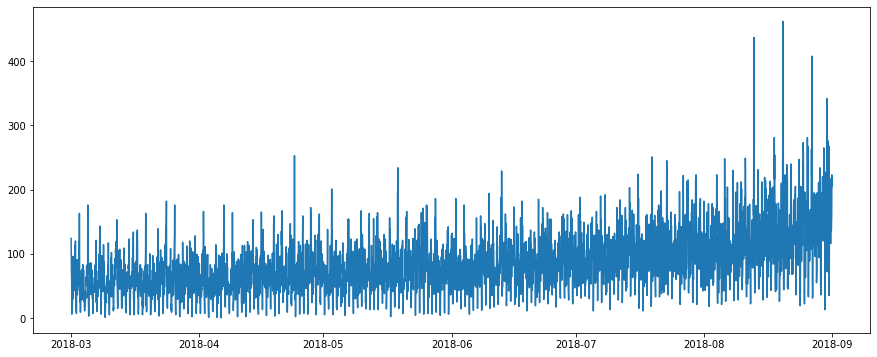

In [6]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(taxi)

Разложим временной ряд на тренд и сезонную компоненту с помощью функции `seasonal_decompose()` библиотеки `statsmodels`.

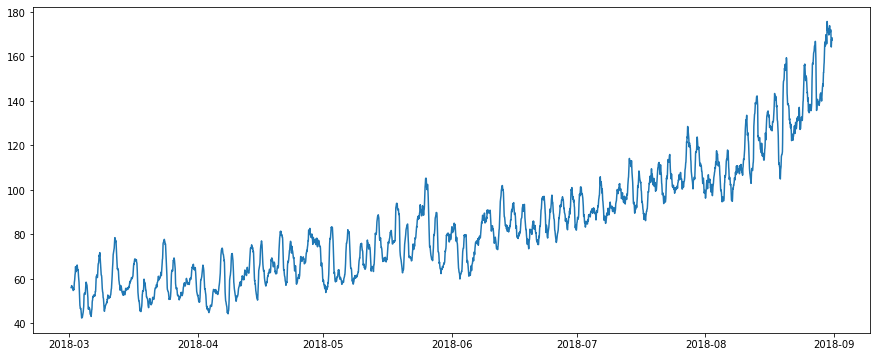

In [7]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(seasonal_decompose(taxi).trend)
plt.show()

На диаграмме виден восходящий тренд: количество заказов такси в аэропортах со временем растет. Проанализируем сезонность временного ряда на отрезке, равном одному дню.

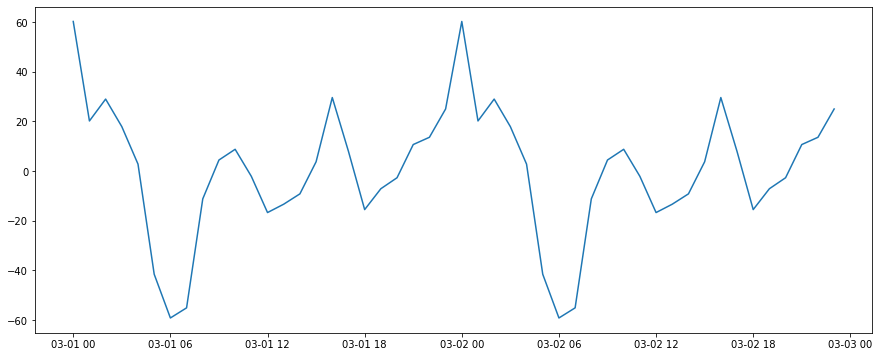

In [8]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(seasonal_decompose(taxi).seasonal['2018-03-01':'2018-03-02'])
plt.show()

По графику видно, что пик заказов такси приходится на полночь и падает к утру, затем снова растет. 

Проверим, является ли временной ряд стационарным: для этого найдем его среднее и стандартное отклонение и отобразим на графике.

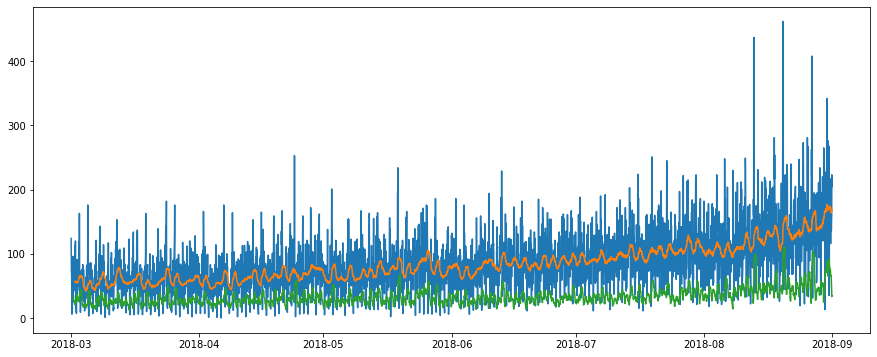

In [9]:
taxi_copy = taxi.copy()

taxi_copy['mean'] = taxi_copy['num_orders'].rolling(24).mean()
taxi_copy['std'] = taxi_copy['num_orders'].rolling(15).std()

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(taxi_copy)

По диаграмме видно, что значение среднего и стандартного отклонения меняются со временем, т.е. временной ряд не является стационарным.

Сделаем ряд стационарным: найдем разности временного ряда методом `shift()`.

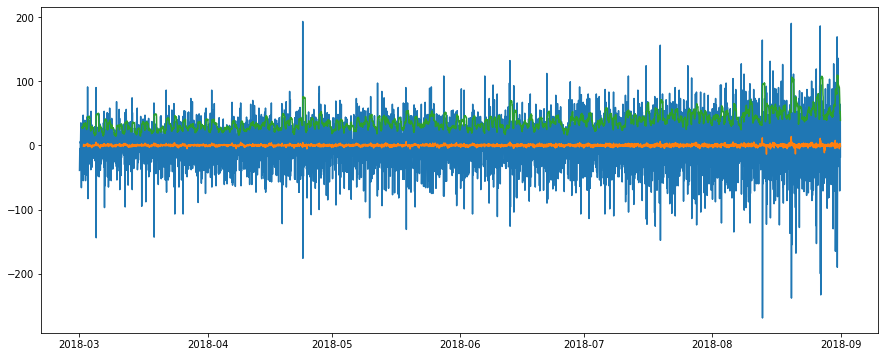

In [10]:
taxi_copy_2 = taxi.copy()

taxi_copy_2 = taxi_copy_2 - taxi_copy_2.shift()
taxi_copy_2['mean'] = taxi_copy_2['num_orders'].rolling(24).mean()
taxi_copy_2['std'] = taxi_copy_2['num_orders'].rolling(15).std()

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(taxi_copy_2)

### Выводы

На этапе анализа данных мы смогли определить тренд к росту заказов такси во времени, а также нашли сезонность в течение суток: количество заказов увеличивается к полуночи, затем падает и начинает расти только утром. На основании значений среднего и стандартного отклонения был сделан вывод о нестационарности временного ряда.

Перейдем к обучению и тестированию моделей обучения.

## Обучение и тестирование моделей

Для решения задачи прогнозирования будем использовать три модели:
* линейная регрессия;
* случайный лес;
* градиентный бустинг.

Создадим признаки для прогнозирования в один шаг: 
- среднее число заказов такси по часам `hour_average`;
- среднее число заказов такси по дням недели `week_average`;
- признак выходного дня `is_weekend`;
- отстающие значения `lag_1`, `lag_2`, `lag_3`.

Напишем функцию расчета среднего числа заказов такси по часам и дням недели `get_mean()`.

In [11]:
def get_mean(data, cat_feature, new_feature):
    return dict(data.groupby(cat_feature)[new_feature].mean())

Теперь создадим функцию по генерации признаков для обучения модели `make_features()` и вызовем ее для нашего датасета.

In [12]:
def make_features(data, max_lag):
    data['hour'] = data.index.hour
    data['weekday'] = data.index.weekday
    data['is_weekend'] = data.index.weekday.isin([5,6])*1
    
    data['weekday_average'] = list(map(get_mean(data, 'weekday', 'num_orders').get, data.weekday))
    data['hour_average'] = list(map(get_mean(data, 'hour', 'num_orders').get, data.hour))
    
    data.drop(['hour', 'weekday'], axis=1, inplace=True)
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

make_features(taxi, 3)

Поделим исходный набор данных на обучающую и тестовую выборки в отношении 9:1 с помощью метода `train_test_split()`.

In [13]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train = train.dropna()

train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

Проверим размеры полученных выборок функцией `shape`.

In [14]:
print(train_features.shape, test_features.shape)

(3971, 6) (442, 6)


Обучим модель линейной регресси и найдем значение метрики RMSE.

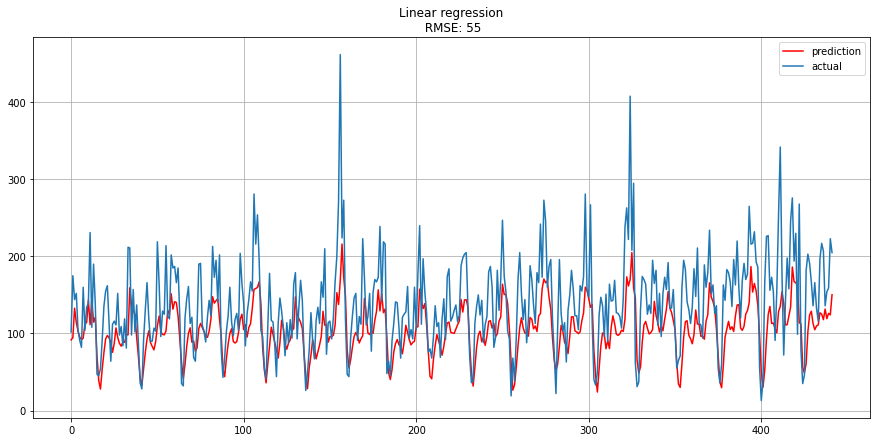

In [15]:
model = LinearRegression(normalize=False)
model.fit(train_features, train_target)
prediction = model.predict(test_features)

plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(test_target.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n RMSE: {}".format
          (round(mean_squared_error(prediction, test_target, squared=False))))
plt.grid(True)

Значение квадратичной ошибки RMSE модели линейной регрессии = 55, что не удовлетворяет условиям задачи. 

Определим лучшую модель случайного леса, изменяя значения гиперпараметров `n_estimators` и `max_depth`.

In [16]:
param_grid = {'n_estimators': range(10, 31, 10), 'max_depth': range(1, 6)}

tscv = TimeSeriesSplit(n_splits=5)

clf = (GridSearchCV(RandomForestRegressor(random_state=777),
                    param_grid, cv=tscv, scoring='neg_mean_squared_error'))
best_model = (clf.fit(train_features, train_target))
print(f'Лучшая модель на обучающей выборке: {best_model.best_estimator_}')

Лучшая модель на обучающей выборке: RandomForestRegressor(max_depth=5, n_estimators=20, random_state=777)


Обучим модель случайного леса с наилучшими гиперпараметрами, найденными на предыдущим этапе, и определим значение RMSE-меры.

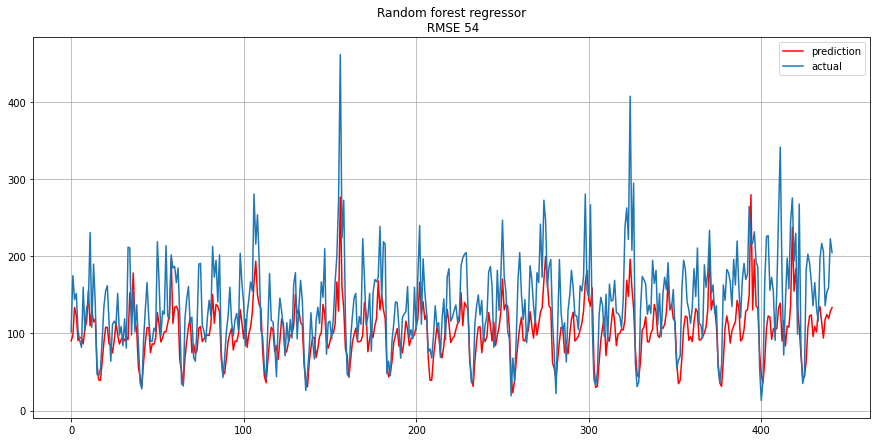

In [17]:
model = RandomForestRegressor(max_depth=5, n_estimators=20, random_state=777)
model.fit(train_features, train_target)
prediction = model.predict(test_features)

plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(test_target.values, label="actual")
plt.legend(loc="best")
plt.title("Random forest regressor\n RMSE {}".format
          (round(mean_squared_error(prediction, test_target, squared=False))))
plt.grid(True)

Значение RMSE для модели случайного леса равно 54 и немногим лучше значения ошибки для модели линейной регрессии.

Перейдем к обучению модели градиентного бустинга библиотеки LightGBM. Подберем наилучшее значение гиперпараметра `max_depth`модели методом `GridSearchCV()`.

In [18]:
param_grid = {'max_depth': range(1, 6)}

tscv = TimeSeriesSplit(n_splits=5)
clf = (GridSearchCV(LGBMRegressor(random_state=777),
                    param_grid, cv=tscv, scoring='neg_mean_squared_error'))
best_model = (clf.fit(train_features, train_target))
print(f'Лучшая модель на обучающей выборке: {best_model.best_estimator_}')

Лучшая модель на обучающей выборке: LGBMRegressor(max_depth=4, random_state=777)


Обучим модель градиентного бустинга на обучающей выборке и найдем значение метрики RMSE на тестовой выборке.

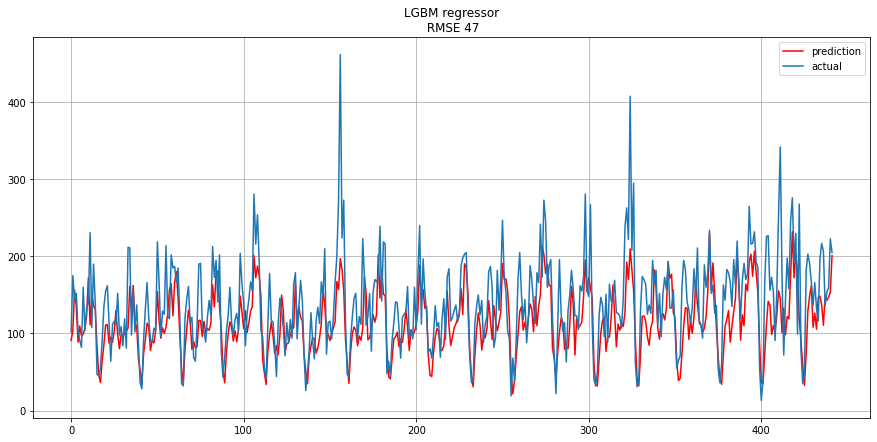

In [19]:
model = LGBMRegressor(max_depth=4, random_state=777)
model.fit(train_features, train_target)
prediction = model.predict(test_features)

plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(test_target.values, label="actual")
plt.legend(loc="best")
plt.title("LGBM regressor\n RMSE {}".format
          (round(mean_squared_error(prediction, test_target, squared=False))))
plt.grid(True)

Модель градиентного бустинга смогла достичь лучшего значения RMSE = 47 на тестовой выборке, что удовлетворяет условиям задачи.

### Выводы

В качестве моделей обучения были выбраны линейная регрессия, случайный лес и градиентный бустинг. Изменяя значения гиперпараметров мы смогли достичь на тестовой выборке лучшего значения RMSE-меры. 

Лучшее качество показала модель градиентного бустинга с глубиной дерева, равной 4 (RMSE = 47). Значение квадратичной ошибки для модели линейной регресси и случайного леса 55 и 54 соответственно.

## Общий вывод

На основе данных о заказах такси из аэропортов в периоде времени было проведено обучение трех моделей: линейная регрессия, случайный лес и градиентный бустинг для прогнозирования количества заказов на следующий час. Для каждой модели были определены гиперпараметры, позволяющие добиться лучшего значения RMSE-метрики.

Наилучшее качество показала модель градиентного бустинга с глубиной дерева, равной 4. На тестовой выборке модель обучения достигла значения RMSE-меры = 47, что удовлетворяет условиям исследования. Модель линейной регрессии и случайного леса, состоящего из 20 деревьев с глубиной дерева 5, не смогли достичь требуемого значения квадратичной ошибки (не более 48).

Таким образом, выбирая модель машинного обучения для решения задачи исследования, особое внимание следует обратить на модель градиентного бустинга LGBM.